In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
import joblib
import os

RSEED = 42
sns.set(style="whitegrid")


# 1) Load dataset

In [2]:
df = pd.read_csv("xAPI-Edu-Data.csv")
print("Dataset shape:", df.shape)


Dataset shape: (480, 17)


# 2) Create target churn

In [3]:
df['churn'] = (df['Class'].astype(str).str.upper() == 'L').astype(int)

print("Churn distribution (value counts):")
print(df['churn'].value_counts())
print(df.head())

Churn distribution (value counts):
churn
0    353
1    127
Name: count, dtype: int64
  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey P

# 3) Quick exploratory data analysis (EDA)

In [4]:
print("\n--- Info ---")
print(df.info())
print("\n--- Missing values ---")
print(df.isnull().sum())

print("\n--- Unique counts ---")
print(df.nunique())



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  Parentschool

# 4) Decide features (numeric vs categorical)

In [5]:
numeric_features = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']
print("\nNumeric describe:")
print(df[numeric_features].describe())


Numeric describe:
       raisedhands  VisITedResources  AnnouncementsView  Discussion
count   480.000000        480.000000         480.000000  480.000000
mean     46.775000         54.797917          37.918750   43.283333
std      30.779223         33.080007          26.611244   27.637735
min       0.000000          0.000000           0.000000    1.000000
25%      15.750000         20.000000          14.000000   20.000000
50%      50.000000         65.000000          33.000000   39.000000
75%      75.000000         84.000000          58.000000   70.000000
max     100.000000         99.000000          98.000000   99.000000



Correlation matrix:
                   raisedhands  VisITedResources  AnnouncementsView  \
raisedhands           1.000000          0.691572           0.643918   
VisITedResources      0.691572          1.000000           0.594500   
AnnouncementsView     0.643918          0.594500           1.000000   
Discussion            0.339386          0.243292           0.417290   
churn                -0.582997         -0.662061          -0.504153   

                   Discussion     churn  
raisedhands          0.339386 -0.582997  
VisITedResources     0.243292 -0.662061  
AnnouncementsView    0.417290 -0.504153  
Discussion           1.000000 -0.270451  
churn               -0.270451  1.000000  


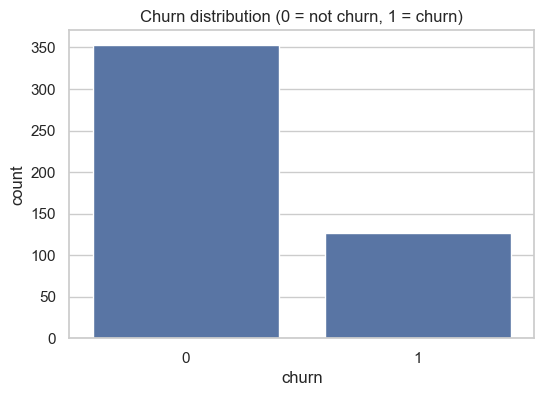

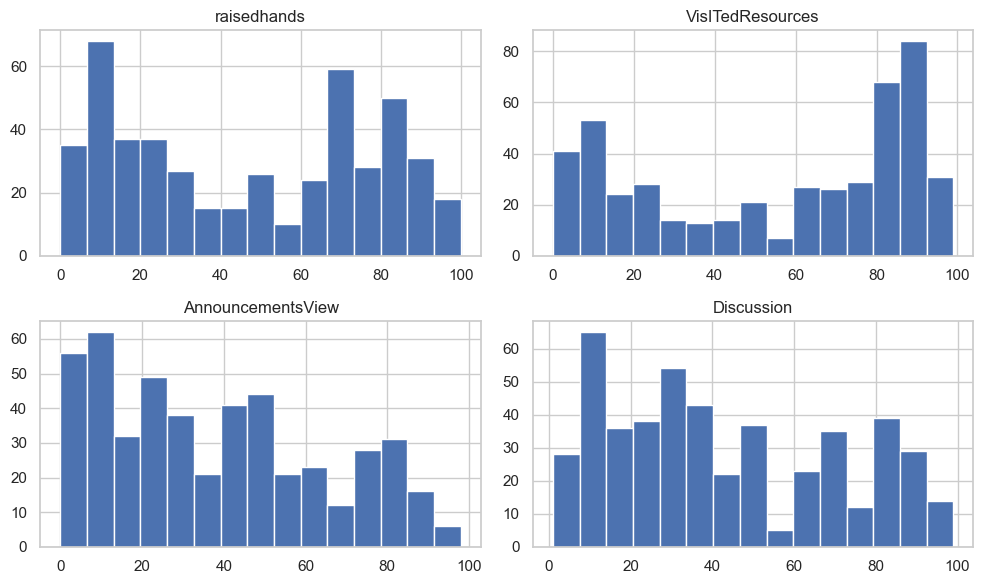

Numeric features: ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
Categorical features: ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays']


In [6]:
corr_cols = numeric_features + ['churn']
print("\nCorrelation matrix:")
print(df[corr_cols].corr())   # removed numeric_only param to avoid version issues

# plots (optional)
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df)
plt.title("Churn distribution (0 = not churn, 1 = churn)")
plt.show()

df[numeric_features].hist(bins=15, figsize=(10,6))
plt.tight_layout()
plt.show()

# ---------------------------
# 3) Prepare feature lists
# ---------------------------
# Exclude 'Class' and 'churn' from categorical features
exclude_cols = {'Class', 'churn'}
categorical_features = [c for c in df.columns if df[c].dtype == 'object' and c not in exclude_cols]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


# 5) Preprocessing pipeline

In [8]:
ohe_params = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder().__init__.__code__.co_varnames:
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(**ohe_params))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])


In [9]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RSEED, class_weight='balanced', n_jobs=-1))
])

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RSEED))
])

# 6) Train / test split

In [10]:
# ---------------------------
X = df[numeric_features + categorical_features]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RSEED
)

print("Train churn ratio:", y_train.mean(), "| Test churn ratio:", y_test.mean())

# ---------------------------
# 7) Fit baseline models
# ---------------------------
print("\nFitting Random Forest (baseline)...")
rf_pipeline.fit(X_train, y_train)

print("\nFitting Gradient Boosting (baseline)...")
gb_pipeline.fit(X_train, y_train)


Train churn ratio: 0.265625 | Test churn ratio: 0.2604166666666667

Fitting Random Forest (baseline)...

Fitting Gradient Boosting (baseline)...


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 10) Evaluate models (classification report, ROC AUC, confusion matrix)


Random Forest (baseline) - Classification Report:
              precision    recall  f1-score   support

           0     0.9200    0.9718    0.9452        71
           1     0.9048    0.7600    0.8261        25

    accuracy                         0.9167        96
   macro avg     0.9124    0.8659    0.8856        96
weighted avg     0.9160    0.9167    0.9142        96

Random Forest (baseline) - ROC AUC: 0.9865
Random Forest (baseline) - Confusion Matrix:
 [[69  2]
 [ 6 19]]
Random Forest (baseline) - Average Precision (AP): 0.9518


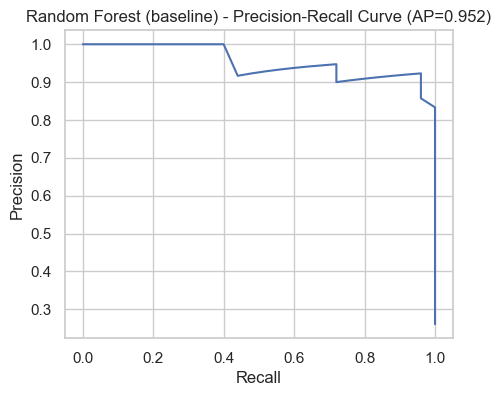


Gradient Boosting (baseline) - Classification Report:
              precision    recall  f1-score   support

           0     0.9452    0.9718    0.9583        71
           1     0.9130    0.8400    0.8750        25

    accuracy                         0.9375        96
   macro avg     0.9291    0.9059    0.9167        96
weighted avg     0.9368    0.9375    0.9366        96

Gradient Boosting (baseline) - ROC AUC: 0.9820
Gradient Boosting (baseline) - Confusion Matrix:
 [[69  2]
 [ 4 21]]
Gradient Boosting (baseline) - Average Precision (AP): 0.9423


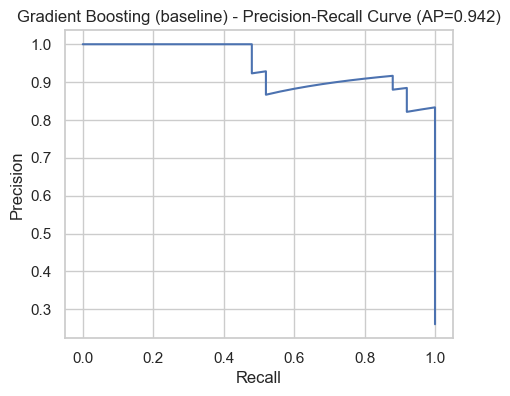

In [11]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
        else:
            y_proba = np.zeros(len(y_test))

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} - ROC AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} - Confusion Matrix:\n", cm)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    print(f"{name} - Average Precision (AP): {ap:.4f}")

    plt.figure(figsize=(5,4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} - Precision-Recall Curve (AP={ap:.3f})")
    plt.grid(True)
    plt.show()

# Evaluate both
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest (baseline)")
evaluate_model(gb_pipeline, X_test, y_test, "Gradient Boosting (baseline)")


# Save best model

In [13]:
best_model = rf_pipeline  # pick RF as best for now
joblib.dump(best_model, "best_churn_model.joblib")
print("Saved best model to: best_churn_model.joblib")

# ---------------------------
# 10) Predict churn scores for all users
# ---------------------------
id_candidates = ['userID','UserID','ID','Id','studentID','StudentID']
id_col = None
for c in id_candidates:
    if c in df.columns:
        id_col = c
        break
if id_col is None:
    df['user_index'] = df.index
    id_col = 'user_index'

df_features = df[numeric_features + categorical_features]
df['churn_score'] = best_model.predict_proba(df_features)[:,1]

high_risk = df.sort_values('churn_score', ascending=False)[[id_col] + numeric_features + categorical_features + ['churn_score']].head(50)
high_risk.to_csv("high_risk_users.csv", index=False)
print("Saved high-risk users to high_risk_users.csv")
print(high_risk.head(10))

Saved best model to: best_churn_model.joblib
Saved high-risk users to high_risk_users.csv
     user_index  raisedhands  VisITedResources  AnnouncementsView  Discussion  \
130         130            7                 9                  5          30   
349         349           15                 4                 12           7   
12           12            5                 1                  0          11   
2             2           10                 7                  0          30   
348         348           20                 3                  9           3   
85           85            1                 0                  1          12   
335         335           15                 7                 12           7   
78           78           13                 3                 11           9   
81           81            8                25                  1          70   
204         204           29                10                 12          24   

    gender Nationa